# 1. 라이브러리 임포트 및 환경 설정

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# 2. 데이터 및 액션 이름 로드

In [2]:
dataset_path = os.path.join('create_dataset', 'dataset')

# seq_*.npy 파일 목록 가져오기
seq_files = [f for f in os.listdir(dataset_path) if f.startswith('seq_') and f.endswith('.npy')]

# 액션 이름 추출
actions = set()
for filename in seq_files:
    parts = filename.split('_')
    action_name = '_'.join(parts[1:-1])
    actions.add(action_name)

# 액션 이름을 리스트로 변환 및 정렬
actions = sorted(actions)
print(f"Detected actions: {actions}")

# 액션 이름 저장
np.save('actions.npy', np.array(actions))

# 액션 이름과 레이블 매핑 생성
action_to_label = {action: idx for idx, action in enumerate(actions)}
print(f"Action to label mapping: {action_to_label}")

Detected actions: ['paper', 'rock', 'sissor']
Action to label mapping: {'paper': 0, 'rock': 1, 'sissor': 2}


# 3. 데이터 및 레이블 로드

In [3]:
data_list = []
label_list = []

for filename in seq_files:
    parts = filename.split('_')
    action_name = '_'.join(parts[1:-1])
    label = action_to_label[action_name]

    seq_data = np.load(os.path.join(dataset_path, filename))
    data_list.append(seq_data)

    labels = np.full((seq_data.shape[0],), label)
    label_list.append(labels)

data = np.concatenate(data_list, axis=0)
labels = np.concatenate(label_list, axis=0)

print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

Data shape: (2609, 30, 103)
Labels shape: (2609,)


# 3-1. 데이터 모양 확인

In [4]:
# After loading data and labels
print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Feature vector size: {data.shape[2]}')  # Verify feature vector size

Data shape: (2609, 30, 103)
Labels shape: (2609,)
Feature vector size: 103


# 4. 입력 데이터 및 레이블 준비

In [5]:
x_data = data.astype(np.float32)
y_data = tf.keras.utils.to_categorical(labels, num_classes=len(actions))

print(f'x_data shape: {x_data.shape}')
print(f'y_data shape: {y_data.shape}')


x_data shape: (2609, 30, 103)
y_data shape: (2609, 3)


# 5. 데이터 분할

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.1, random_state=2021, stratify=labels
)

print(f'Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}')


Training data shape: (2348, 30, 103), Training labels shape: (2348, 3)
Validation data shape: (261, 30, 103), Validation labels shape: (261, 3)


# 6. 모델 구축

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,187 (176.51 KB)

 Trainable params: 45,187 (176.51 KB)

 Non-trainable params: 0 (0.00 B)

# 7. 모델 학습

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

os.makedirs('models', exist_ok=True)

callbacks = [
    ModelCheckpoint(
        'models/best_model.keras',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        verbose=1,
        mode='max'
    )
]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3819 - loss: 72.5454
Epoch 1: val_accuracy improved from -inf to 0.81226, saving model to models/best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3915 - loss: 69.0160 - val_accuracy: 0.8123 - val_loss: 5.1961 - learning_rate: 0.0010
Epoch 2/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8540 - loss: 4.2758
Epoch 2: val_accuracy improved from 0.81226 to 0.93487, saving model to models/best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8547 - loss: 4.2495 - val_accuracy: 0.9349 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 3/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9106 - loss: 1.0051
Epoch 3: val_accuracy did not improve from 0.93487
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9099 - loss: 1.0148 - val_accuracy: 0.8736 - val_loss: 1.5819 - learning_rate: 0.0010
Epoch 4/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9172 - loss: 0.8856


# 8. 학습 결과 시각화

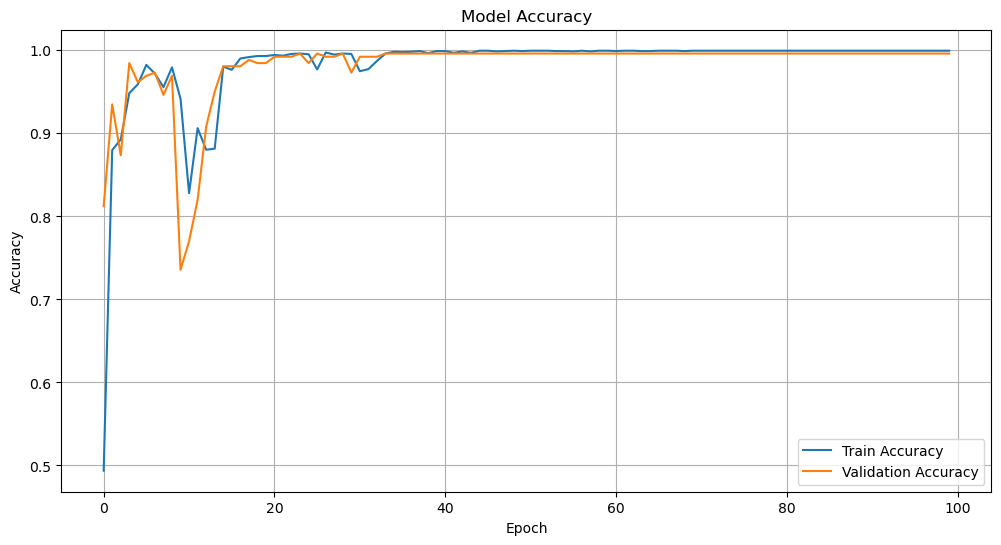

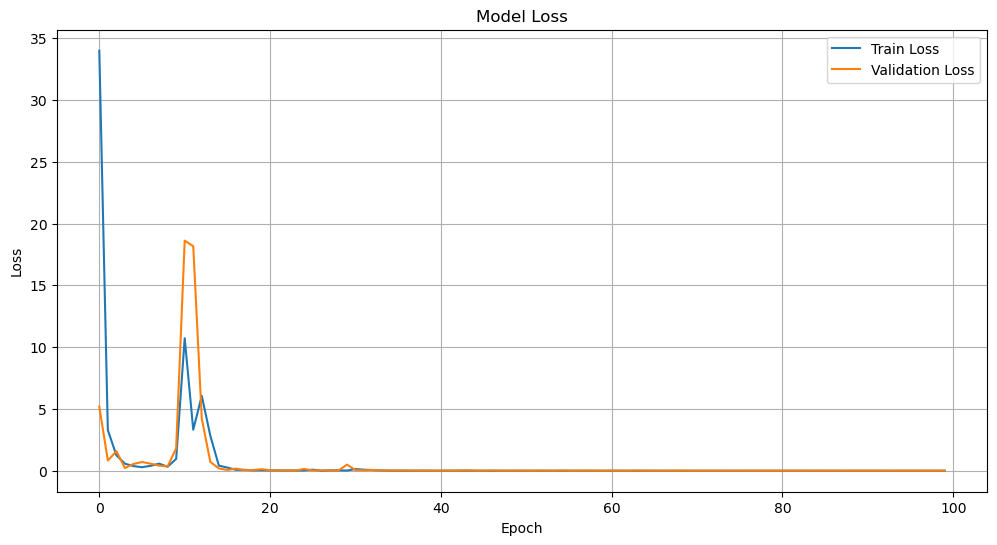

In [10]:
# 정확도
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 손실
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# 9. 모델 평가

In [11]:
# 9. 모델 평가
best_model = tf.keras.models.load_model('models/best_model.keras')

val_loss, val_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 0.0188
Validation Accuracy: 0.9962


# 10. 혼동 행렬 및 분류 보고서

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


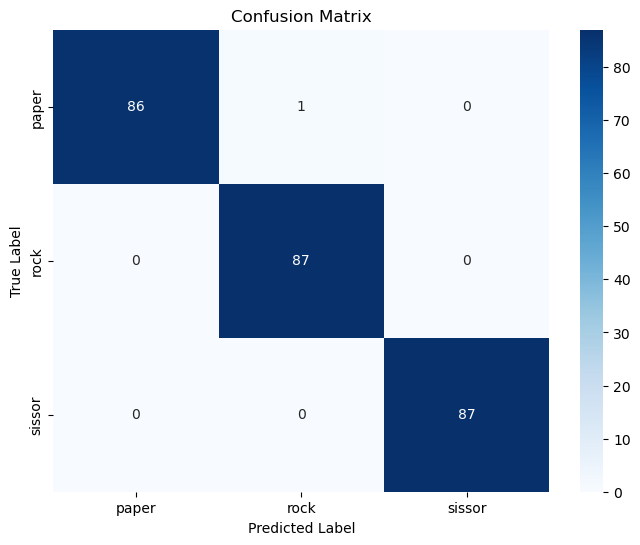

Classification Report:
               precision    recall  f1-score   support

       paper       1.00      0.99      0.99        87
        rock       0.99      1.00      0.99        87
      sissor       1.00      1.00      1.00        87

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



In [12]:
# 10. 혼동 행렬 및 분류 보고서
y_pred = best_model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# 혼동 행렬
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=actions, yticklabels=actions, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 분류 보고서
report = classification_report(y_true, y_pred_classes, target_names=actions)
print('Classification Report:\n', report)

# 11. 최종 모델 저장

In [13]:
best_model.save('models/final_model.keras')